# Deconvolve impulses with both ARA and ARIANNA responses

### Nov 5, 2020

## Code

In [181]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
# sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
sys.path.insert(1, '/users/PCON0003/cond0068/pyrex/pyrex')
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
import deDisperse_util as util
from pyrex.internal_functions import normalize
my_path_plots = os.path.abspath("./plots/")
import pyrex.custom.ara as ara
import pyrex.custom.arianna as arianna
pyrex


<module 'pyrex' from '/users/PCON0003/cond0068/.local/lib/python3.6/site-packages/pyrex/__init__.py'>

In [182]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")


## Deconvolve ARA

In [229]:
def deAmplify_ARA(time,voltage):
    fft_v,fft_f, dT = util.doFFT(time,voltage)
    norm = max(abs(antV.interpolate_filter(fft_f*1E6)))
    fft_v=antV.interpolate_filter(fft_f*1E6)*fft_v/norm
    wf = util.doInvFFT(fft_v)
    return wf

def deAmplify_ARIANNA(time,voltage):
    fft_v,fft_f, dT = util.doFFT(time,voltage)
    norm = max(abs(antV_arianna.interpolate_filter(fft_f*1E6)))
    fft_v=antV_arianna.interpolate_filter(fft_f*1E6)*fft_v/norm
    wf = util.doInvFFT(fft_v)
    return wf
    

In [297]:
from scipy import signal
pol_ev = np.array([0.309,1,0.904519])
dirProp = np.array([0.904519,0,-0.309])

# dirProp = random_three_vector()
phi = np.arctan2(dirProp[1],dirProp[0])
print("phi:%0.2f"%phi)
theta = np.arccos(dirProp[2])
print("theta:%0.2f"%np.degrees(theta))

wform = pd.read_pickle("./wform_forDebug_PyREx.pkl")
wform.voltage = wform.voltage/5


sig = pyrex.Signal(wform["time"]*1E-9,wform.voltage*1E-3,'voltage') # times in seconds
new_times = np.linspace(-30*1E-9,120*1E-9,4096)
sig = sig.with_times(new_times)
antV = ara.VpolAntenna(name="Dummy Vpol", position=(0, 0, 0), power_threshold=0)
antV.set_orientation(z_axis=(0, 0, 1), x_axis=(1, 0, 0))
output = antV.apply_response(sig, direction=dirProp, polarization=pol_ev, force_real=True)
# output = antV.front_end(sig)

timeV = output.times*1E9 #in ns
voltageV = output.values*1E3 #in mV

phi:0.00
theta:108.00


In [298]:
# fft_v, fft_f, dT = util.doFFT(timeV,voltageV)
# response_filter = np.array(antV.interpolate_filter(fft_f*1E6))
# # response_filter = np.divide(response_filter,abs(response_filter))
# # fft_v = fft_v*response_filter
# deDis_wf = sig.filter_frequencies(response_filter)
# # deDis_wf = util.doInvFFT(deDis_wf)


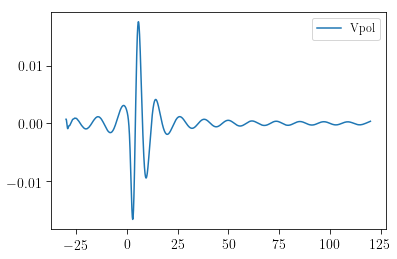

In [299]:
plt.plot(timeV,voltageV, label="Vpol")
# plt.plot(timeV,deDis_wf, label="Vpol2")
# plt.plot(fft_f,fft_v)
# plt.xlim(0,1000)
plt.legend()
# plt.yscale("log")

## Deconvolve ARIANNA

In [300]:
antV_arianna = arianna.LPDA(name="Dummy LPDA", position=(0, 0, 0), threshold=0)
antV_arianna.set_orientation(z_axis=(0, 0, 1), x_axis=(1,0, 0))
output_arianna = antV_arianna.apply_response(sig, direction=np.array([1/np.sqrt(2),0,1/np.sqrt(2)]), polarization=np.array([0,0,1]), force_real=True)
# output_arianna = antV_arianna.front_end(output_arianna)
timeV_arianna = output_arianna.times*1E9 #in ns
voltageV_arianna = output_arianna.values*1E3 #in mV


In [301]:
voltageV_noAmp = deAmplify_ARA(timeV,voltageV)
voltageV_noAmp_ARIANNA = deAmplify_ARIANNA(timeV,voltageV_arianna)

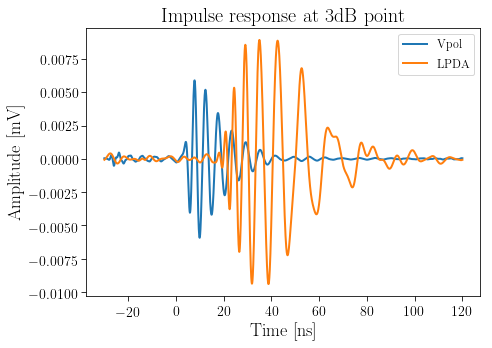

In [303]:
plt.figure(figsize=(7,5))
plt.title("Impulse response at 3dB point")
plt.plot(timeV,voltageV_noAmp,lw=2, label="Vpol")
plt.plot(timeV_arianna,voltageV_noAmp_ARIANNA,lw=2, label=r"LPDA")
# plt.plot(sig.times*1E9,sig.values*1E2,lw=2, label = r"Original impulse [scaled$/10$]")
plt.xlabel("Time [ns]")
plt.legend()
plt.ylabel("Amplitude [mV]")
plt.tight_layout()
plt.savefig(my_path_plots+'/Dumpster/ARA_ARIANNA_Wforms_3dB.png', dpi=150)


In [276]:
15/1.41

10.638297872340425

## Antenna response

In [269]:
# dec_t, dec_v, dir_res = deConvolve_ARIANNA(timeV, voltageV, np.pi/2,0,0)
direction=np.array([1/np.sqrt(2),0,1/np.sqrt(2)])
polarization=np.array([0,1,0])
origin = antV_arianna.position - normalize(direction)
r, theta, phi = antV_arianna.antenna._convert_to_antenna_coordinates(origin)
# Calculate polarization vector in the antenna coordinates
y_axis = np.cross(antV_arianna.antenna.z_axis, antV_arianna.antenna.x_axis)
transformation = np.array([antV_arianna.antenna.x_axis, y_axis, antV_arianna.antenna.z_axis])
ant_pol = np.dot(transformation, normalize(polarization))
# Calculate directional response as a function of frequency
# directive_response = antV_arianna.antenna.directional_response(theta, phi, ant_pol)(fft_f*1E6)
print(np.degrees(theta))
print(np.degrees(phi))
print(180-np.degrees(np.arccos(direction[2])))

135.0
180.0
135.0


In [295]:
direction=np.array([0.904519,0,-0.309])
polarization=np.array([0.309,1,0.904519])
origin = antV.position - normalize(direction)
r, theta, phi = antV.antenna._convert_to_antenna_coordinates(origin)
# Calculate polarization vector in the antenna coordinates
y_axis = np.cross(antV.antenna.z_axis, antV_arianna.antenna.x_axis)
transformation = np.array([antV.antenna.x_axis, y_axis, antV.antenna.z_axis])
ant_pol = np.dot(transformation, normalize(polarization))

print(np.degrees(theta))
print(np.degrees(phi))
print(180-np.degrees(np.arccos(direction[2])))

71.13890779315743
180.0
72.00102381206236


0.0

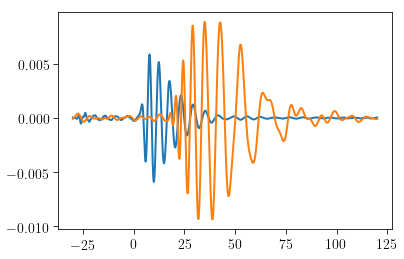

In [307]:
# plt.plot(timeV,voltageV,lw=2, label="Vpol")
plt.plot(timeV,voltageV_noAmp,lw=2, label="Vpol")
plt.plot(timeV,voltageV_noAmp_ARIANNA,lw=2, label="Vpol")


In [308]:
print("Vpol integral")
np.sum(voltageV_noAmp**2)
ARA_powInt = np.trapz(voltageV_noAmp**2,x=timeV )

Vpol integral


In [309]:
print("LPDA integral")
ARIANNA_powInt = np.trapz(voltageV_noAmp_ARIANNA**2,x=timeV )

LPDA integral


In [310]:
print("Ratio power integral LPDA/Vpol")

ARIANNA_powInt/ARA_powInt

Ratio power integral LPDA/Vpol


5.8627528617395575

In [311]:
ARA_peak = max(abs(voltageV_noAmp))
ARIANNA_peak = max(abs(voltageV_noAmp_ARIANNA))

In [312]:
print("Ratio peak max amplitude LPDA/Vpol")

ARIANNA_peak/ARA_peak

Ratio peak max amplitude LPDA/Vpol


1.586330660839197

In [237]:
freq = np.linspace(0,1000,1001)
# phis = 
directive_response_ARA = antV.antenna.directional_response(np.pi/2, 0, polarization=np.array([0,0,1]))(freq*1E6)
heff_ARA = antV.antenna.frequency_response(freq*1E6)
response_ARA = directive_response_ARA*heff_ARA

directive_response_ARIANNA = antV_arianna.antenna.directional_response(np.pi, 0, ant_pol)(freq*1E6)
heff_ARIANNA = antV_arianna.antenna.frequency_response(freq*1E6)
response_ARIANNA = directive_response_ARIANNA*heff_ARIANNA

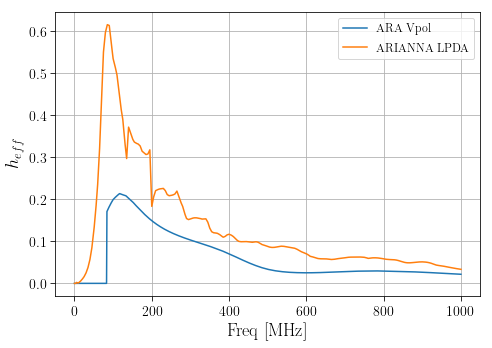

In [238]:
plt.figure(figsize=(7,5))

plt.plot(freq,abs(response_ARA), label="ARA Vpol")
plt.plot(freq,abs(response_ARIANNA), label = "ARIANNA LPDA")
plt.legend()
plt.xlabel("Freq [MHz]")
plt.ylabel("$h_{eff}$")
plt.tight_layout()
plt.grid()

# plt.savefig(my_path_plots+'/Dumpster/ARA_ARIANNA_heff.png', dpi=150)


In [85]:
ARA_filter = antV.interpolate_filter(freq*1E6)
ARIANNA_filter = antV_arianna.interpolate_filter(freq*1E6)

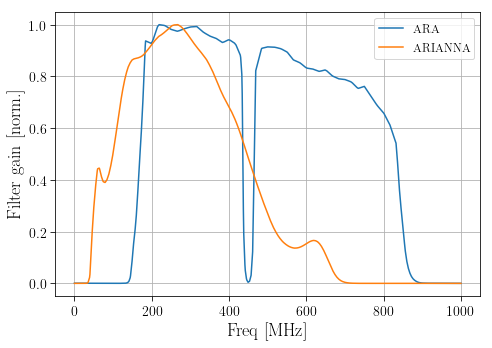

In [95]:
plt.figure(figsize=(7,5))

plt.plot(freq,abs(ARA_filter)/max(abs(ARA_filter)), label="ARA")
plt.plot(freq,abs(ARIANNA_filter)/max(abs(ARIANNA_filter)), label = "ARIANNA")
plt.legend()
plt.xlabel("Freq [MHz]")
plt.ylabel("Filter gain [norm.]")
plt.grid()
# plt.xscale("")
plt.tight_layout()


# plt.savefig(my_path_plots+'/Dumpster/ARA_ARIANNA_filter.png', dpi=150)


In [258]:
theta = np.radians(np.linspace(0,180,181))
phi = 0 
directive_response_ARIANNA = np.array([antV_arianna.antenna.directional_response(theta, np.pi, ant_pol)(300*1E6) for theta in theta])
directive_response_ARA = np.array([antV.antenna.directional_response(theta, 0, polarization=np.array([0,0,1]))(300*1E6) for theta in theta])

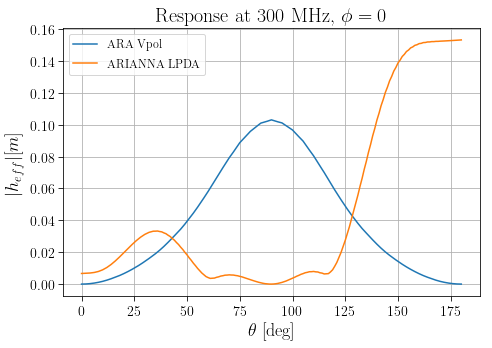

In [259]:
plt.figure(figsize=(7,5))
plt.title("Response at 300 MHz, $\phi = 0$")
plt.plot(np.degrees(theta),abs(directive_response_ARA*heff_ARA[300]), label="ARA Vpol")
plt.plot(np.degrees(theta),abs(directive_response_ARIANNA), label = "ARIANNA LPDA")
plt.legend()
plt.xlabel("$\\theta$ [deg]")
plt.ylabel("$|h_{eff}| [m]$")
plt.tight_layout()
plt.grid()
# plt.savefig(my_path_plots+'/Dumpster/ARA_ARIANNA_heff_300MHz.png', dpi=150)


In [316]:
def PolVectorReco(Peak_V, Peak_H, theta, phi):
    R = Peak_H/Peak_V
    denom = np.sqrt(1+R**2)
    Px = (np.cos(theta)*np.cos(phi)-R*np.sin(phi))/denom
    Py = (R*np.cos(theta)+np.cos(theta)*np.sin(phi))/denom
    Pz = -np.sin(theta)/denom
    np.set_printoptions(suppress=True)
    return np.array([Px,Py,Pz])

In [320]:
PolVectorReco(1,0,np.pi/2,0)

array([ 0.,  0., -1.])

In [324]:
util.getRFChannel(0,1)

8